# 🔡 Character-Level Name Generation with RNN

This lab demonstrates how to build a character-level Recurrent Neural Network (RNN) using PyTorch to generate surnames by language origin.

### 🧠 Objective
Train a model that:
- Takes a **language category** (e.g., French, Arabic, Russian),
- Takes a **starting letter** (e.g., 'A', 'B'),
- And generates **surnames** in that language.

### 📦 Dataset
- A set of text files, each containing names from one language.
- Preprocessing converts names to ASCII and organizes them by category.

### 🏗️ Key Concepts
- Character-level one-hot encoding
- RNN architecture with manual loop over sequence
- Training with negative log-likelihood loss (NLLLoss)
- Name generation using autoregressive sampling

### 🔍 Outcomes
- Visualize training loss over time
- Generate surnames for various languages and initials


### 🔽 Download and Extract Dataset

This cell downloads the character-level name dataset from the official PyTorch tutorial repository. The dataset is provided as a ZIP file and contains several `.txt` files—each file corresponds to a different language and includes names in that language.

- `!wget`: Fetches the ZIP archive from the internet.
- `!unzip`: Extracts the contents into the current working directory.

This dataset is used to train a character-level RNN that classifies names by their language of origin.


In [ ]:
!wget -q https://download.pytorch.org/tutorial/data.zip
!unzip -q data.zip

### 🧰 Import Required Libraries

This cell imports all necessary Python libraries for data preprocessing, file handling, and model building:



In [ ]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt

### 🧹 Data Loading and Normalization Helpers

This cell defines utility functions for file reading and preprocessing:

- `findFiles(path)`: Uses `glob` to list all files matching the given pattern (e.g., all `.txt` files).
  
- `unicodeToAscii(s)`: Converts Unicode strings to plain ASCII by:
  - Applying NFD normalization to split characters from accents.
  - Removing non-spacing marks (diacritics).
  - Filtering out any characters not in the allowed character set (`all_letters`).
  - This ensures consistency and avoids unseen or rare Unicode characters in training.

- `readLines(filename)`: Reads each line (i.e., each name) from a given file and converts it to ASCII using the above function. This returns a list of cleaned name strings.


In [ ]:
# Function to find all the files in path
def findFiles(path):
  return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

### 🗂️ Organize Data by Language Category

This cell prepares the dataset for training by organizing names by their language of origin:

- `all_letters`: Defines the set of valid characters, including letters and common punctuation. An extra token is reserved for the End-of-Sequence (EOS), so we add `+1` to `n_letters`.

- `category_lines`: A dictionary mapping each language (e.g., `'French'`, `'Arabic'`) to a list of names in that language.

- `all_categories`: A list of all language categories, extracted from the file names (e.g., `'French.txt'` becomes `'French'`).

- The loop:
  - Scans all name files in `data/names/`.
  - Extracts the category name from the file name.
  - Reads and cleans all names in that file.
  - Stores them in the dictionary under their respective category.

- `n_categories`: Total number of languages in the dataset.



In [ ]:
# Build the category_lines dictionary, a list of lines per category
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

category_lines = {}
all_categories = []

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [ ]:
# it is usefull ALL THE TIME to understand your data a little bit
print('Number of Categories:', n_categories)
print("Categories: ", all_categories)
print("Examples of Arabic surnames:",category_lines['Arabic'])
print(unicodeToAscii("O'Néàl"))

Number of Categories: 18
Categories:  ['Italian', 'Dutch', 'Arabic', 'Greek', 'French', 'Japanese', 'Vietnamese', 'Scottish', 'Russian', 'English', 'Spanish', 'Czech', 'Korean', 'German', 'Irish', 'Portuguese', 'Chinese', 'Polish']
Examples of Arabic surnames: ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba', 'Sabbagh', 'Attia', 'Tahan', 'Haddad', 'Aswad', 'Najjar', 'Dagher', 'Maloof', 'Isa', 'Asghar', 'Nader', 'Gaber', 'Abboud', 'Maalouf', 'Zogby', 'Srour', 'Bahar', 'Mustafa', 'Hanania', 'Daher', 'Tuma', 'Nahas', 'Saliba', 'Shamoon', 'Handal', 'Baba', 'Amari', 'Bahar', 'Atiyeh', 'Said', 'Khouri', 'Tahan', 'Baba', 'Mustafa', 'Guirguis', 'Sleiman', 'Seif', 'Dagher', 'Bahar', 'Gaber', 'Harb', 'Seif', 'Asker', 'Nader', 'Antar', 'Awad', 'Srour', 'Shadid', 'Hajjar', 'Hanania', 'Kalb', 'Shadid', 'Bazzi', 'Mustafa', 'Masih', 'Ghanem', 'Haddad', 'Isa', 'Antoun', 'Sarraf', 'Sleiman', 'Dagher', 'Najjar', 'Malouf', 'Nahas', 'Naser', 'Saliba', 'Sha

### 🧠 Define the Recurrent Neural Network (RNN) Model

This custom `RNN` class is designed for character-level name classification based on language:

- **Inputs to the model**:
  - `category`: One-hot vector representing the language.
  - `input`: One-hot vector of the current character.
  - `hidden`: Hidden state from the previous time step.

- **Architecture**:
  - `input2hidden`: Takes concatenated vectors of `[category, input, hidden]` and computes a new hidden state.
  - `input2output`: Generates intermediate output from the same concatenated input.
  - `output2output`: Refines the combined `[hidden, output]` to produce the final prediction.
  - `Dropout`: Adds regularization to prevent overfitting.
  - `LogSoftmax`: Converts output logits to log-probabilities for classification.

- **`forward` function**: Describes how data flows through the network during a forward pass.
- **`initHidden` function**: Returns a zero-initialized hidden state (batch size = 1 here).

This structure allows the RNN to learn sequential dependencies in characters while incorporating category information at each step.

![](https://i.imgur.com/jzVrf7f.png)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.input2hidden = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.input2output = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.output2output = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.input2hidden(input_combined)
        output = self.input2output(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.output2output(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size, device=device)

### ✅ Sanity Check: Forward Pass for the Custom Character-Level RNN

Run this simple test to verify that our `RNN` model works as expected:

- **Why?**  
  - Confirms the forward pass completes without error.
  - Checks that input and output tensor shapes are correct.

- **What to expect?**  
  - Output tensor shape: **(1, output_size)**
  - Next hidden state shape: **(1, hidden_size)**

In [ ]:
n_categories = 18
input_size = 10
hidden_size = 8
output_size = 5

# Instantiate model
model = RNN(input_size, hidden_size, output_size).to(device)

# Dummy inputs for sanity check
category = torch.zeros(1, n_categories, device=device)
category[0, 0] = 1

input_char = torch.zeros(1, input_size, device=device)
input_char[0, 2] = 1

hidden = model.initHidden()

# Forward pass
output, next_hidden = model(category, input_char, hidden)

print("Output shape:", output.shape)
print("Next hidden shape:", next_hidden.shape)
print("Output:", output)
print("Next hidden:", next_hidden)

Output shape: torch.Size([1, 5])
Next hidden shape: torch.Size([1, 8])
Output: tensor([[-1.4104, -1.8076, -1.5826, -1.7092, -1.5826]],
       grad_fn=<LogSoftmaxBackward0>)
Next hidden: tensor([[ 0.1095,  0.0932,  0.0919, -0.1875,  0.0783,  0.0904,  0.2849, -0.0138]],
       grad_fn=<AddmmBackward0>)


### 🎲 Generate Random Training Examples

This cell defines helper functions for sampling training data:

- `randomChoice(l)`: Returns a random element from a given list.

- `randomTrainingPair()`:
  - Randomly selects a language `category` from `all_categories`.
  - Then randomly selects a name `line` from that category using `category_lines`.
  - Returns both the category and the corresponding name.

These functions are useful for preparing randomized training batches to prevent overfitting and promote generalization.


In [ ]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be `(category, current letter, hidden state)`
and the outputs will be `(next letter, next hidden state)`. So for each
training set, we\'ll need the category, a set of input letters, and a
set of output/target letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for `"ABCD<EOS>"` we would create (\"A\", \"B\"), (\"B\",
\"C\"), (\"C\", \"D\"), (\"D\", \"EOS\").

![](https://i.imgur.com/JH58tXY.png)

The category tensor is a [one-hot
tensor](https://en.wikipedia.org/wiki/One-hot) of size
`<1 x n_categories>`. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.


### 🔢 Tensor Encoding for Category, Input, and Target

This cell defines functions to convert names and categories into tensor formats suitable for training:

- `categoryTensor(category)`:
  - Converts a language category into a one-hot vector of shape `(1, n_categories)`.
  - The category index is set to 1; all others remain 0.

- `inputTensor(line)`:
  - Converts a name (string) into a sequence of one-hot encoded character vectors.
  - Shape: `(line_length, 1, n_letters)`, where each character is represented by a one-hot vector.

- `targetTensor(line)`:
  - Converts the expected output (i.e., the next character at each time step) into indices.
  - The sequence starts from the second character and ends with an **EOS** (End-of-Sequence) marker.
  - Output is a `LongTensor` used for classification targets.

These encoded representations allow the model to learn sequential character predictions based on category and character history.


In [ ]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor.to(device)

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor.to(device)

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes).to(device)

In [ ]:
# 🔍 Test the tensor conversion functions with an example
example_category, example_line = randomTrainingPair()

print("Category:", example_category)
print("Name:", example_line)

cat_tensor = categoryTensor(example_category)
print("\nCategory Tensor Shape:", cat_tensor.shape)
print("Category Tensor:", cat_tensor)


input_tensor = inputTensor(example_line)
print("\nInput Tensor Shape:", input_tensor.shape)
print("First Input Character (one-hot):", input_tensor[0])

target_tensor = targetTensor(example_line)
print("\nTarget Tensor Shape:", target_tensor.shape)
print("Target Indices:", target_tensor)


Category: German
Name: Herbert

Category Tensor Shape: torch.Size([1, 18])
Category Tensor: tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

Input Tensor Shape: torch.Size([7, 1, 59])
First Input Character (one-hot): tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])

Target Tensor Shape: torch.Size([7])
Target Indices: tensor([ 4, 17,  1,  4, 17, 19, 58])


### 🔄 Generate a Random Training Example (Tensors)

This function creates a full training example from a randomly chosen name and language category:

- `randomTrainingPair()`: Selects a random (category, name) pair.
- `categoryTensor(category)`: One-hot encodes the language.
- `inputTensor(line)`: Converts the name into a sequence of one-hot encoded character tensors.
- `targetTensor(line)`: Converts the target sequence (next characters + EOS) into a tensor of indices.

The function returns all three components:
1. `category_tensor`: Tensor for the language category.
2. `input_line_tensor`: One-hot encoded character sequence.
3. `target_line_tensor`: Index sequence for the expected next characters.

This function is used during training to dynamically create fresh examples.


In [ ]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor.to(device), input_line_tensor.to(device), target_line_tensor.to(device)

### 🏋️ Simplified Training Step for One Name

This function trains the RNN on a single (category, name) example:

- **Loss**: Uses `nn.NLLLoss()` since the model outputs log-probabilities.
- **Optimizer**: `Adam` is used to automatically handle parameter updates.

#### 🔁 `train(...)` Workflow:
1. Prepare tensors and initialize the hidden state.
2. Zero gradients with `optimizer.zero_grad()`.
3. Loop over characters in the input:
   - Pass each character to the RNN.
   - Accumulate loss using the predicted output and target.
4. Call `loss.backward()` to compute gradients.
5. Update parameters using `optimizer.step()`.

This version is cleaner and leverages PyTorch’s optimizer for parameter updates.


In [ ]:
criterion = nn.NLLLoss()
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor = target_line_tensor.unsqueeze(-1)
    hidden = rnn.initHidden()

    optimizer.zero_grad()
    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()
    optimizer.step()

    return output, loss.item() / input_line_tensor.size(0)


To keep track of how long training takes I am adding a
`timeSince(timestamp)` function which returns a human readable string:


In [ ]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

### 🔁 Full Training Loop

This cell runs the main training loop for the RNN:

- **Model Initialization**:
  - `rnn`: New instance of the RNN model.
  - `optimizer`: Adam optimizer for automatic gradient updates.

- **Training Parameters**:
  - `n_iters = 100000`: Number of training iterations.
  - `print_every = 5000`: Print training progress every 5,000 iterations.
  - `plot_every = 500`: Track loss for plotting every 500 iterations.

- **Training Process**:
  - At each iteration, sample a random training example and train the model.
  - Periodically log the loss and append averaged loss values for plotting later.
  - Uses `timeSince` to display elapsed training time in a readable format.

This loop trains the RNN to predict the next character in a name based on both the previous characters and the category (language).


In [ ]:
rnn = RNN(n_letters, 128, n_letters).to(device)
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0005)
n_iters = 50000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 26s (5000 10%) 2.2061
0m 52s (10000 20%) 3.2334
1m 18s (15000 30%) 2.1280
1m 44s (20000 40%) 2.6817
2m 9s (25000 50%) 2.8770
2m 34s (30000 60%) 3.1454
2m 59s (35000 70%) 0.8254
3m 24s (40000 80%) 3.0811
3m 50s (45000 90%) 2.0763
4m 16s (50000 100%) 2.5403


Plotting the Losses
===================

Plotting the historical loss from all\_losses shows the network
learning:


/tmp/ipython-input-15-1818037715.py:8: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


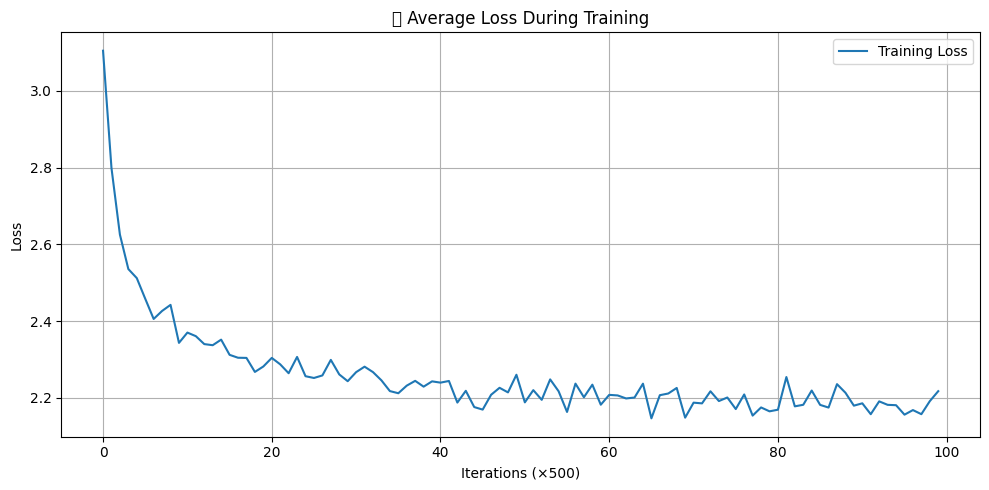

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(all_losses, label='Training Loss')
plt.title("📉 Average Loss During Training")
plt.xlabel("Iterations (×500)")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### ✨ Name Generation (Inference)

This cell defines how to generate new names using the trained RNN model:

#### 🔡 `sample(category, start_letter='A')`
- Generates one name at a time, given a **language category** and a **starting letter**.
- At each step:
  - The model predicts the next character based on the previous one and the hidden state.
  - Generation stops either when:
    - The model outputs the EOS token, or
    - The maximum length (`max_length = 20`) is reached.

#### 🔁 `samples(category, start_letters='ABC')`
- Generates multiple names per category, each starting with a different letter.
- Useful for visualizing how the model behaves with different prefixes.

#### 📦 Example Outputs
This code calls `samples()` on various categories and initials to showcase generated names:
- Russian: Starting with R, U, S
- German: G, E, R
- Spanish: S, P, A
- Chinese: C, H, I
- Arabic: H, A, R

The output shows how well the model has learned character patterns for each language.


In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')
print("---------------------------------------")
samples('German', 'GER')
print("---------------------------------------")
samples('Spanish', 'SPA')
print("---------------------------------------")
samples('Chinese', 'CHI')
print("---------------------------------------")
samples('Arabic', 'HARA')

Romanik
Urinov
Salovan
---------------------------------------
Gres
Estev
Rompa
---------------------------------------
Salaman
Parez
Aberquezi
---------------------------------------
Cha
Hun
Iwa
---------------------------------------
Harde
Abara
Rosha
Abara


### Contirbuted by Yazan Alshoibi
